# Conditional Generative Adversarial Network
CGAN은 기존 GAN에서 추가적인 정보y를 이용하여 conditional모델로 만든 것이다. 추가정보 y는 generator와 discriminator의 input layer에 더해지게 된다.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow.contrib.slim as slim
from scipy.misc import imread, imresize
from tensorflow.examples.tutorials.mnist import input_data

%matplotlib inline
print('tensorflow version is : ',tf.__version__)

tensorflow version is :  1.2.1


# Download MNIST Dataset

In [2]:
mnist = input_data.read_data_sets('./data/mnist', one_hot=True) # download

Extracting ./data/mnist\train-images-idx3-ubyte.gz
Extracting ./data/mnist\train-labels-idx1-ubyte.gz
Extracting ./data/mnist\t10k-images-idx3-ubyte.gz
Extracting ./data/mnist\t10k-labels-idx1-ubyte.gz


# Hyperparameter settings

In [3]:
batch_size = 128
noise_size = 128
n_class = 10
epoch = 101

learning_rate = 0.001

# Define functions
GAN network를 구성할 function들을 선언한다.

get_session : tensorflow의 세션을 정의한다.<br />
make_noise : G에 사용될 noise를 생성<br />
lrelu : 활성함수 leaky relu를 구현<br />
generator_conv : convolution layer를 사용한 generator 구현<br />
discriminator_conv : convolution layer를 사용한 discriminator 구현<br />
loss_lsgan : LSGAN에 사용되는 목적함수 E[(D(x|y)-1)^2]x0.5 + E[(D(G(z|y))^2)]x0.5, E[(D(z|y)-1)^2]x0.5<br />
display : 결과 이미지 출력

In [4]:
def get_session():
    config = tf.ConfigProto()
    config.allow_soft_placement=True
    config.gpu_options.allow_growth = False
    config.log_device_placement=False
    sess = tf.Session(config = config)
    
    return sess
    
def make_noise(batch_size, noise_size):
    return np.random.randn(batch_size, noise_size)    
    
def lrelu(x, leak=0.2, name="lrelu"):
    return tf.maximum(x, leak*x)

    
    
def generator_conv(Z,Y, feat_map1, feat_map2, filter_size, is_training = True, name = 'Generator_conv'):
    with tf.variable_scope(name):
        
        Z = tf.concat([Z, Y],1)
       
        L1 = slim.fully_connected(Z, 1024, activation_fn = tf.nn.relu, 
                                   weights_initializer = slim.xavier_initializer(), normalizer_fn = slim.batch_norm, normalizer_params = {'is_training' : is_training})
        
        L2 = slim.fully_connected(L1, 7*7*128, activation_fn = tf.nn.relu, 
                                   weights_initializer = slim.xavier_initializer(), normalizer_fn = slim.batch_norm, normalizer_params = {'is_training' : is_training})
        L2 = tf.reshape(L2, [-1,7,7,128])
        L3 = slim.conv2d_transpose(L2, feat_map1,filter_size,stride = 2, padding = 'SAME', activation_fn = tf.nn.relu, 
                                   weights_initializer = slim.xavier_initializer(), normalizer_fn = slim.batch_norm, normalizer_params = {'is_training' : is_training}, scope = 'slim_conv_transpose1')
        L4 = slim.conv2d_transpose(L3, feat_map2,filter_size,stride = 2, padding = 'SAME', activation_fn = tf.nn.sigmoid, 
                                   weights_initializer =slim.xavier_initializer() ,scope = 'slim_conv_transpose2')
        L4 = tf.reshape(L4, [-1,784])
        return L4
    
def discriminator_conv(Z,Y, feat_map1,feat_map2, filter_size, is_training=True, name = 'Discriminator_conv', reuse = None):
    with tf.variable_scope(name) as disc:
        if reuse:
            disc.reuse_variables()
        
        init = slim.xavier_initializer()
        fn = lrelu
        Z = tf.reshape(Z, [-1, 28, 28, 1]) # transter to 4dim in slim
        
         
        Z = tf.concat([Z,Y],3) # [batch_size, 28, 28, n_class]을 concat하여 [batch_size, 28, 28, 11]로 만든다
        
        
        L1 = slim.conv2d(Z, feat_map1,filter_size, padding = 'SAME', activation_fn = fn, weights_initializer = init,
                         normalizer_fn = slim.batch_norm,normalizer_params = {'is_training' : is_training}, scope = 'slim_conv1')
        
        L2 = slim.conv2d(L1, feat_map2,filter_size, padding = 'SAME', activation_fn = fn, weights_initializer = init,
                         normalizer_fn = slim.batch_norm, normalizer_params = {'is_training' : is_training},scope = 'slim_conv2')
        
        L2 = slim.flatten(L2, scope = 'flatten_slim_layer')

        
        L3 = slim.fully_connected(L2, 512, activation_fn = fn, weights_initializer = init,
                         normalizer_fn = slim.batch_norm, normalizer_params = {'is_training' : is_training})
        
        L4 = slim.fully_connected(L3, 1, activation_fn = tf.nn.sigmoid)
        

        
        return L4
    
def loss_gan(D_real, D_fake):
    loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = D_real, 
                                                                           labels = tf.ones_like(D_real)))
    loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = D_fake, 
                                                                           labels = tf.zeros_like(D_fake)))
    loss_G = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = D_fake, 
                                                                           labels = tf.ones_like(D_fake)))
    return loss_real + loss_fake, loss_G


def loss_lsgan(D_real, D_fake):
    loss_D = tf.reduce_mean(tf.square(D_real - 1) + tf.square(D_fake))*0.5
             
    loss_G = tf.reduce_mean(tf.square(D_fake - 1))*0.5
    return loss_D, loss_G


def display(sess, G, noise,labels, fig_num=5):
    
 
    images = sess.run(G, feed_dict = {Z:noise, Y:labels, is_training:False})

    
    fig = plt.figure(figsize=(15,8))
    for i in range(fig_num):
        snap = fig.add_subplot(1, fig_num, i+1)
        snap.set_xticks([])
        snap.set_yticks([])
        
        label = np.where(labels[i]==1)
        snap.set_title('{}'.format(int(label[0])))
        plt.imshow(images[i].reshape([28, 28]), cmap = 'gray')
    plt.show()

# CGAN setting
    * Loss of D = E[(D(x|y)-1)^2]/2+ E[D(G(z|y))^2]/2
    * Loss of G = E[D(G(z|y))]/2

In [5]:
X = tf.placeholder(tf.float32, [None, 784])
Z = tf.placeholder(tf.float32, [None, noise_size])
Y = tf.placeholder(tf.float32, [None, n_class])
Y_trans = tf.placeholder(tf.float32, [None, 28,28,n_class])

is_training = tf.placeholder(tf.bool)

G = generator_conv(Z,Y, 64, 1, [3,3])
D_real = discriminator_conv(X,Y_trans, 64, 64, [5,5])
D_fake = discriminator_conv(G,Y_trans, 64, 64, [5,5], reuse = True)

loss_D, loss_G = loss_lsgan(D_real, D_fake)

g_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope = 'Generator')
d_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope = 'Discriminator')


d_optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate/2)
g_optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)

d_grad = d_optimizer.compute_gradients(loss_D, d_vars)
g_grad = g_optimizer.compute_gradients(loss_G, g_vars)

update_d = d_optimizer.apply_gradients(d_grad)
update_g = g_optimizer.apply_gradients(g_grad)

# Train CGAN with least suqares loss

Epoch : 0, D_loss = 0.2188, G_loss = 0.2927


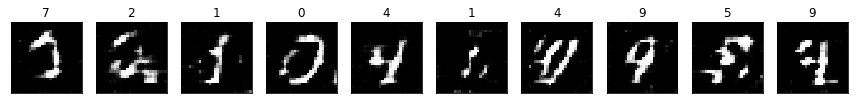

Epoch : 10, D_loss = 0.2107, G_loss = 0.2068


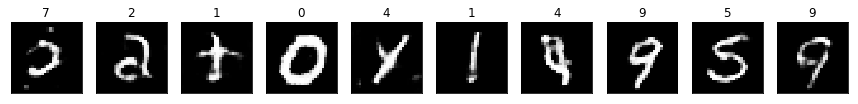

Epoch : 20, D_loss = 0.2403, G_loss = 0.1761


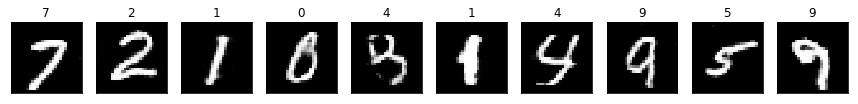

Epoch : 30, D_loss = 0.1207, G_loss = 0.2941


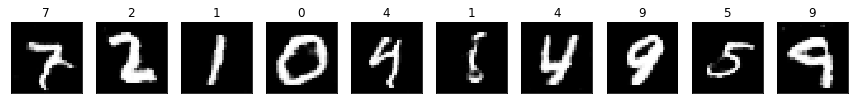

Epoch : 40, D_loss = 0.1522, G_loss = 0.2480


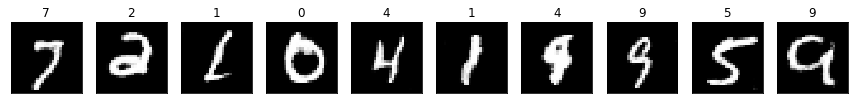

Epoch : 50, D_loss = 0.1396, G_loss = 0.3691


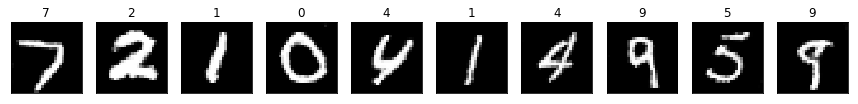

Epoch : 60, D_loss = 0.1442, G_loss = 0.2902


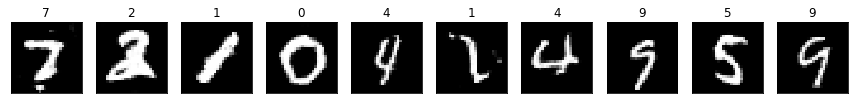

Epoch : 70, D_loss = 0.1033, G_loss = 0.3369


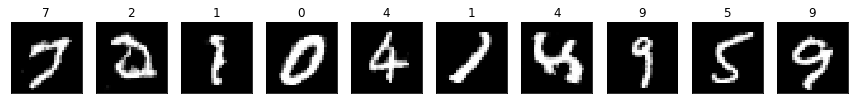

Epoch : 80, D_loss = 0.0572, G_loss = 0.4265


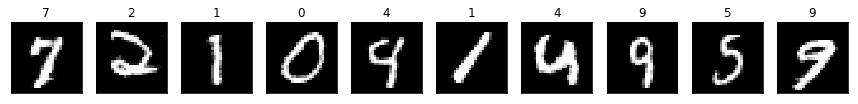

Epoch : 90, D_loss = 0.0896, G_loss = 0.3851


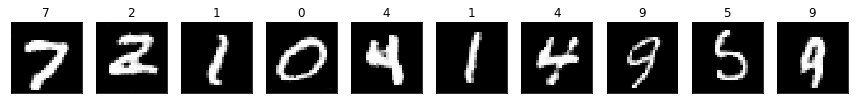

Epoch : 100, D_loss = 0.0853, G_loss = 0.4049


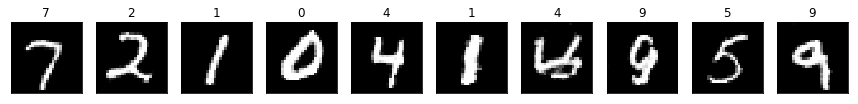

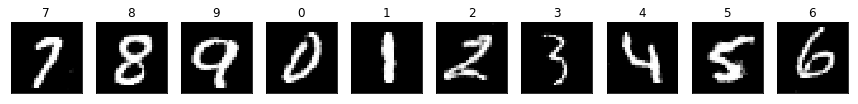

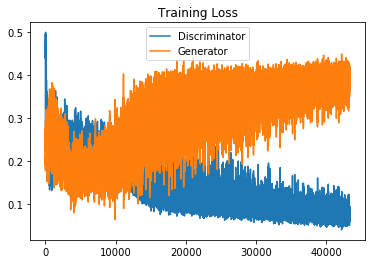

In [6]:
with get_session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    
    total_loss = []
    for step in range(epoch):
        loss_val_D, loss_val_G = 0,0
        total_batch = int(mnist.train.num_examples/batch_size)
        
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            noise_z = make_noise(batch_size, noise_size)
            
            
            # label정보를 추가하기 위해 데이터 reshape하여 [batch_size, 28, 28, n_class]로 만든 뒤에 concat한다
            batch_ys_re = batch_ys.reshape([batch_size,1,1,n_class])
            batch_ys_tranform = batch_ys_re*np.ones([batch_size, 28, 28, n_class])

            _, loss_val_D = sess.run([update_d, loss_D], feed_dict = {X:batch_xs, Y_trans:batch_ys_tranform, Y:batch_ys
                                                                       , Z:noise_z, is_training:True})
            _, loss_val_G = sess.run([update_g, loss_G], feed_dict = {Z:noise_z, Y_trans:batch_ys_tranform,
                                                                      Y:batch_ys, is_training:True})
            total_loss.append([loss_val_D, loss_val_G])
        
        if step%10==0:
            print('Epoch : {}, D_loss = {:.4f}, G_loss = {:.4f}'.format(step, loss_val_D, loss_val_G))
            g_size = 10
            z = make_noise(g_size, noise_size)
            display(sess, G, z, mnist.test.labels[:g_size], fig_num = g_size)
            
    g_size = 10
    z = make_noise(g_size, noise_size)
    display(sess, G, z, mnist.test.labels[-g_size:], fig_num = g_size)    
    
    total_loss = np.array(total_loss)
    plt.plot(total_loss.T[0], label = 'Discriminator')
    plt.plot(total_loss.T[1], label = 'Generator')
    plt.title("Training Loss")
    plt.legend()
    plt.show()